In [1]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00


In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import supervision
import transformers
import pytorch_lightning

print(
    "; supervision:", supervision.__version__, 
    "; transformers:", transformers.__version__, 
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
; supervision: 0.3.0 ; transformers: 4.51.3 ; pytorch_lightning: 2.5.1.post0


In [3]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
import cv2
import warnings
import supervision as sv
warnings.filterwarnings('ignore')

2025-05-17 09:08:20.239918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747472900.460175      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747472900.526291      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT, size=800)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [5]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "annotations.json"
TRAIN_DIRECTORY = os.path.join("/kaggle/input/mdp-dac-204/output", "train")
VAL_DIRECTORY = os.path.join("/kaggle/input/mdp-dac-204/output", "val")
TEST_DIRECTORY = os.path.join("/kaggle/input/mdp-dac-204/output", "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY, 
    image_processor=image_processor, 
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of training examples: 12000
Number of validation examples: 1500
Number of test examples: 1500


In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [7]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def on_train_epoch_end(self):
        # Print training loss at the end of each epoch
        train_loss = self.trainer.callback_metrics.get("training_loss")
        if train_loss is not None:
            print(f"\nEpoch {self.current_epoch}: Train Loss = {train_loss:.4f}")
            
        # You can also print individual loss components if needed
        for k in self.trainer.callback_metrics.keys():
            if k.startswith("train_") and k != "training_loss":
                print(f"  - {k} = {self.trainer.callback_metrics[k]:.4f}")
                print()
    
    def on_validation_epoch_end(self):
        # Print validation loss at the end of each epoch
        val_loss = self.trainer.callback_metrics.get("validation_loss")
        if val_loss is not None:
            print(f"Epoch {self.current_epoch}: Validation Loss = {val_loss:.4f}")
            
        # You can also print individual validation loss components
        for k in self.trainer.callback_metrics.keys():
            if k.startswith("validation_") and k != "validation_loss":
                print(f"  - {k} = {self.trainer.callback_metrics[k]:.4f}")

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

Image #31582


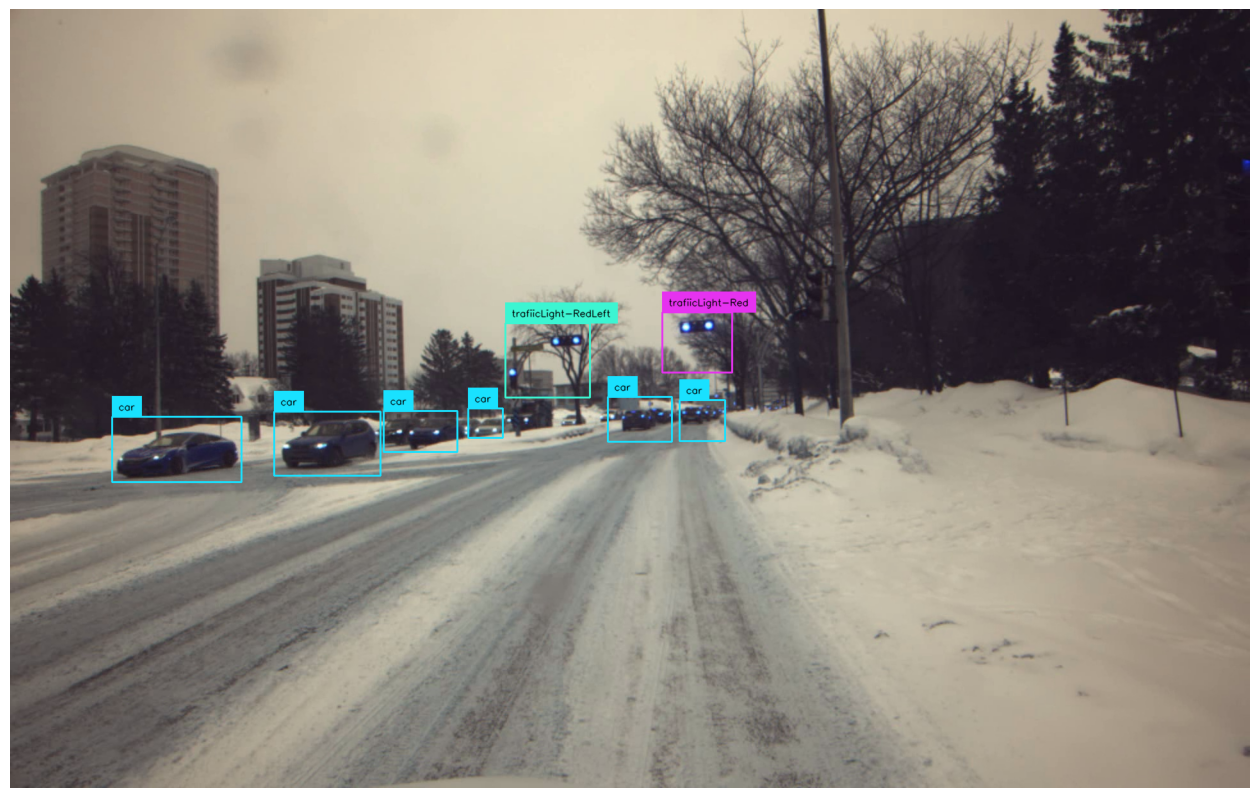

In [8]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print(f"Image #{image_id}")

# Load image and annotations
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.loadAnns(TRAIN_DATASET.coco.getAnnIds(imgIds=[image_id]))

image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)

# Check if image is loaded properly
if image is None:
    raise ValueError(f"Image at path {image_path} could not be loaded.")

# Annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# Prepare id2label mapping for labels
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

# Annotate the image with bounding boxes
box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

# Display the image with annotations
plt.figure(figsize=(16, 16))
plt.imshow(frame)
plt.axis('off')  # Hide axes for better display
plt.show()


In [9]:
import os
import tensorflow as tf

# Define a log directory
log_dir = "/kaggle/working/tb_logs"

# Create a callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
model = Detr.load_from_checkpoint(
    "/kaggle/input/mdp-dac-204/lightning_logs/version_0/checkpoints/epoch=14-step=5625.ckpt",
    lr=1e-4,
    lr_backbone=1e-5,
    weight_decay=1e-4
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [11]:
device = next(model.parameters()).device  # Automatically get model's device

batch = next(iter(TRAIN_DATALOADER))
pixel_values = batch['pixel_values'].to(device)
pixel_mask = batch['pixel_mask'].to(device)

outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)


In [12]:
outputs.logits.shape

torch.Size([4, 100, 13])

In [13]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar
# settings
MAX_EPOCHS = 30

trainer = Trainer(devices=1, max_epochs=MAX_EPOCHS, 
                  gradient_clip_val=0.1, 
                  callbacks=[TQDMProgressBar(refresh_rate=10)],
                  accumulate_grad_batches=8, 
                  log_every_n_steps=5)

In [15]:
trainer.fit(
    model=model,
    ckpt_path="/kaggle/input/mdp-dac-204/lightning_logs/version_0/checkpoints/epoch=14-step=5625.ckpt"  # Optional but ensures resume from last step
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.7024
  - validation_loss_bbox = 0.0462
  - validation_loss_giou = 0.3550
  - validation_cardinality_error = 6.3750


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.4128
  - validation_loss_bbox = 0.0295
  - validation_loss_giou = 0.3857
  - validation_cardinality_error = 3.8333

Epoch 15: Train Loss = 0.9074
  - train_loss_ce = 0.3395

  - train_loss_bbox = 0.0105

  - train_loss_giou = 0.2576

  - train_cardinality_error = 4.0000



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.4262
  - validation_loss_bbox = 0.0295
  - validation_loss_giou = 0.3765
  - validation_cardinality_error = 3.8687

Epoch 16: Train Loss = 2.0830
  - train_loss_ce = 0.6049

  - train_loss_bbox = 0.0415

  - train_loss_giou = 0.6353

  - train_cardinality_error = 4.7500



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.4180
  - validation_loss_bbox = 0.0288
  - validation_loss_giou = 0.3696
  - validation_cardinality_error = 5.1747

Epoch 17: Train Loss = 0.8800
  - train_loss_ce = 0.2468

  - train_loss_bbox = 0.0262

  - train_loss_giou = 0.2512

  - train_cardinality_error = 3.2500



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3810
  - validation_loss_bbox = 0.0285
  - validation_loss_giou = 0.3664
  - validation_cardinality_error = 5.3000

Epoch 18: Train Loss = 0.8109
  - train_loss_ce = 0.1541

  - train_loss_bbox = 0.0128

  - train_loss_giou = 0.2964

  - train_cardinality_error = 2.5000



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3937
  - validation_loss_bbox = 0.0288
  - validation_loss_giou = 0.3835
  - validation_cardinality_error = 3.7660

Epoch 19: Train Loss = 1.1638
  - train_loss_ce = 0.2752

  - train_loss_bbox = 0.0152

  - train_loss_giou = 0.4064

  - train_cardinality_error = 5.7500



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3780
  - validation_loss_bbox = 0.0285
  - validation_loss_giou = 0.3650
  - validation_cardinality_error = 4.1933

Epoch 20: Train Loss = 1.3838
  - train_loss_ce = 0.4486

  - train_loss_bbox = 0.0230

  - train_loss_giou = 0.4102

  - train_cardinality_error = 3.5000



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3727
  - validation_loss_bbox = 0.0275
  - validation_loss_giou = 0.3563
  - validation_cardinality_error = 4.1420

Epoch 21: Train Loss = 0.8230
  - train_loss_ce = 0.1142

  - train_loss_bbox = 0.0166

  - train_loss_giou = 0.3128

  - train_cardinality_error = 3.0000



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3642
  - validation_loss_bbox = 0.0277
  - validation_loss_giou = 0.3593
  - validation_cardinality_error = 3.2720

Epoch 22: Train Loss = 1.0046
  - train_loss_ce = 0.1967

  - train_loss_bbox = 0.0120

  - train_loss_giou = 0.3740

  - train_cardinality_error = 3.5000



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3657
  - validation_loss_bbox = 0.0286
  - validation_loss_giou = 0.3753
  - validation_cardinality_error = 3.6893

Epoch 23: Train Loss = 0.8172
  - train_loss_ce = 0.1134

  - train_loss_bbox = 0.0313

  - train_loss_giou = 0.2737

  - train_cardinality_error = 2.0000



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3564
  - validation_loss_bbox = 0.0275
  - validation_loss_giou = 0.3595
  - validation_cardinality_error = 3.8060

Epoch 24: Train Loss = 0.7703
  - train_loss_ce = 0.1317

  - train_loss_bbox = 0.0197

  - train_loss_giou = 0.2701

  - train_cardinality_error = 2.2500



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3477
  - validation_loss_bbox = 0.0270
  - validation_loss_giou = 0.3567
  - validation_cardinality_error = 4.7047

Epoch 25: Train Loss = 0.9343
  - train_loss_ce = 0.3775

  - train_loss_bbox = 0.0157

  - train_loss_giou = 0.2391

  - train_cardinality_error = 3.2500



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3599
  - validation_loss_bbox = 0.0282
  - validation_loss_giou = 0.3659
  - validation_cardinality_error = 3.2520

Epoch 26: Train Loss = 0.9093
  - train_loss_ce = 0.2750

  - train_loss_bbox = 0.0167

  - train_loss_giou = 0.2755

  - train_cardinality_error = 1.2500



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3552
  - validation_loss_bbox = 0.0281
  - validation_loss_giou = 0.3632
  - validation_cardinality_error = 4.8173

Epoch 27: Train Loss = 0.6783
  - train_loss_ce = 0.1008

  - train_loss_bbox = 0.0112

  - train_loss_giou = 0.2607

  - train_cardinality_error = 3.2500



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3706
  - validation_loss_bbox = 0.0281
  - validation_loss_giou = 0.3615
  - validation_cardinality_error = 4.8133

Epoch 28: Train Loss = 0.9203
  - train_loss_ce = 0.2756

  - train_loss_bbox = 0.0304

  - train_loss_giou = 0.2463

  - train_cardinality_error = 4.5000



Validation: |          | 0/? [00:00<?, ?it/s]

  - validation_loss_ce = 0.3619
  - validation_loss_bbox = 0.0269
  - validation_loss_giou = 0.3578
  - validation_cardinality_error = 3.3713

Epoch 29: Train Loss = 1.4849
  - train_loss_ce = 0.3372

  - train_loss_bbox = 0.0267

  - train_loss_giou = 0.5071

  - train_cardinality_error = 1.0000



In [16]:
 MODEL_PATH = os.path.join('/kaggle/working/', 'custom-model-v2')

In [17]:
model.model.save_pretrained(MODEL_PATH)